In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import scipy


In [63]:
def thermal_bosonic_bath(temperature, frequency):
    if frequency == 0:
        f = 0.000001
    else:
        f = frequency
    return 1/(np.exp(f/(temperature))-1)


def spectral_density_drude(c, frequency, cutoff_frequency):
    if frequency == 0:
        f = 0.000001
    else:
        f = frequency
    return c*f/(1 + (f/cutoff_frequency)**2)


def bath_correlation_function_inf(c, cutoff_frequency, temperature, matsub_number, frequency):
    realpart = spectral_density_drude(
        c, frequency, cutoff_frequency)*thermal_bosonic_bath(temperature, frequency)
    imag_temp_ind = -c*cutoff_frequency/2
    imag_vacuum_fluc = (c*cutoff_frequency*frequency**2) / \
        (2*(cutoff_frequency**2+frequency**2))
    i = np.array(range(1, matsub_number))
    matsub = np.array((2*np.pi*i*temperature)/((1-(2*np.pi*i*temperature/cutoff_frequency)
                      ** 2)*(frequency**2 + (2*np.pi*i*temperature)**2)), dtype=complex)
    imag_thermal_noise = (frequency*c)*((-cutoff_frequency**2)/(2*(cutoff_frequency**2 +
                                                                   frequency**2)*np.tan(cutoff_frequency/(2*temperature)))+(2*temperature)*np.sum(matsub))
    return complex(realpart, imag_temp_ind + imag_vacuum_fluc + imag_thermal_noise)

def Szt_inf(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension):
    plus_frequenz = bath_correlation_function_inf(
        c, cutoff_frequency, temperatur, matsub_number, frequency)
    minus_frequenz = bath_correlation_function_inf(
        c, cutoff_frequency, temperatur, matsub_number, -frequency)
    St = np.array([[0]*dimension for j in range(dimension)], dtype=complex)
    for i in range(dimension):
        if i+1 < dimension:
            St[i][i+1] = minus_frequenz*np.sqrt(i+1)/2
        if i-1 > -1:
            St[i][i-1] = plus_frequenz*np.sqrt(i)/2
    return St


def S_dim(dimension):
    S = np.array([[0]*dimension for j in range(dimension)], dtype=complex)
    for i in range(dimension):
        if i+1 < dimension:
            S[i][i+1] = np.sqrt(i+1)/2
        if i-1 > -1:
            S[i][i-1] = np.sqrt(i)/2
    return S


def Hs_dim(dimension):
    Hs = np.array([[0]*dimension for j in range(dimension)], dtype=complex)
    for i in range(dimension):
        Hs[i][i] = i+1/2
    return Hs


def Sij(i, j):
    if i==j-1:
        return np.sqrt(j)/2
    elif i == j+1:
        return np.sqrt(j+1)/2
    else:
        return 0


def coh_mat(dimension, alpha):
    C = np.array([[0]*dimension for j in range(dimension)], dtype=complex)
    for i in range(dimension):
        for j in range(dimension):
            C[i][j] = np.exp(-(abs(alpha)**2))*(alpha**i)*(np.conjugate(alpha)**j) / \
                (np.sqrt(np.math.factorial(i))*np.sqrt(np.math.factorial(j)))
    return C


def Redfield_inf(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rho):
    Sztt = Szt_inf(c, cutoff_frequency, temperatur,
                   matsub_number, frequency, dimension)
    S = S_dim(dimension)
    Hs = Hs_dim(dimension)
    komm = Hs@rho - rho@Hs
    Dred = S@rho@Sztt.conj().T + Sztt@rho@S - S@Sztt@rho - rho@Sztt.conj().T@S
    return complex(0, -1)*komm + Dred

def Hls_total(c, cutoff_frequency, temperature, matsub_number, frequency, dimension):
    Hls = np.array([[0]*dimension for j in range(dimension)], dtype=complex)
    for m in range(dimension):
        for n in range(dimension):
            for k in range(dimension):
                if np.logical_and(Sij(m,k)!=0, Sij(m,n)!=0):
                    Hls[k][n] = Hls[k][n] + np.conj(Sij(m, k))*Sij(m, n)*(bath_correlation_function_inf(
                        c, cutoff_frequency, temperature, matsub_number, frequency*(m-n))-np.conj(bath_correlation_function_inf(
                        c, cutoff_frequency, temperature, matsub_number, frequency*(m-k))))/complex(0,2)
    return Hls


def Hls_sekular(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension):
    Hls_sek = np.array(
        [[0]*dimension for j in range(dimension)], dtype=complex)
    for m in range(dimension):
        for n in range(dimension):
            if Sij(m,n)!=0:
                Hls_sek[n][n] = Hls_sek[n][n] + np.abs(Sij(m,n))**2*np.imag(bath_correlation_function_inf(
        c, cutoff_frequency, temperatur, matsub_number, frequency*(m-n)))
    return Hls_sek


def Hls_non_sekular(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension):
    return Hls_total(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension) - Hls_sekular(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension)

def Dtotal(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rho):
    Dtot = np.array(
        [[0]*dimension for j in range(dimension)], dtype=complex)
    for m in range(dimension):
        for n in range(dimension):
            for q in range(dimension):
                for k in range(dimension):
                    if np.logical_and(Sij(m,n)!=0, Sij(q,k)!=0):
                        Dtot[m][q] = Dtot[m][q] + Sij(m,n)*np.conj(Sij(q,k))*(np.conj(bath_correlation_function_inf(
                             c, cutoff_frequency, temperatur, matsub_number, frequency*(q-k)))+ bath_correlation_function_inf(
                            c, cutoff_frequency, temperatur, matsub_number, frequency*(m-n)))*rho[n][k]
                    
                    if np.logical_and(Sij(n, q) != 0, Sij(q, k) != 0):
                        Dtot[m][k] = Dtot[m][k] - 0.5*rho[m][n]*Sij(n,q)*Sij(q,k)*(bath_correlation_function_inf(
                           c, cutoff_frequency, temperatur, matsub_number, frequency*(q-k)))

                    if np.logical_and(Sij(m,n)!=0, Sij(n,q)!=0):   
                        Dtot[m][k] = Dtot[m][k] - 0.5*Sij(m,n)*Sij(n, q)*rho[k][q]*np.conj(bath_correlation_function_inf(
                           c, cutoff_frequency, temperatur, matsub_number, frequency*(n-m)))
                    
                    if np.logical_and(Sij(m,n)!=0,Sij(n,q)!=0):
                        Dtot[m][k] = Dtot[m][k] - 0.5*Sij(m, n)*Sij(n, q)*rho[q][k]*bath_correlation_function_inf(
                           c, cutoff_frequency, temperatur, matsub_number, frequency*(n-q))
                        
                    if np.logical_and(Sij(q, n) != 0, Sij(q, k) != 0):
                        Dtot[m][k] = Dtot[m][k] - 0.5*np.conj(Sij(q, n))*Sij(q, k)*rho[m][n]*np.conj(bath_correlation_function_inf(
                            c, cutoff_frequency, temperatur, matsub_number, frequency*(q-n)))
                    
    return Dtot

def Dtotal_matrix(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rho):
    Sztt = Szt_inf(c, cutoff_frequency, temperatur,
                   matsub_number, frequency, dimension)
    S = S_dim(dimension)

    return S@rho@Sztt.conj().T + Sztt@rho@S - 0.5*(S@Sztt@rho + rho@S@Sztt + Sztt.conj().T@S@rho + rho@Sztt.conj().T@S)

def Dsekular(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rho):
    Dsek = np.array(
        [[0]*dimension for j in range(dimension)], dtype=complex)
    for m in range(dimension):
        for n in range(dimension):
            if Sij(m,n)!=0:
                Dsek[m][m] = Dsek[m][m] + 2*Sij(m,n)*np.conj(Sij(m,n))*rho[n][n]*(np.real(
                    bath_correlation_function_inf(c, cutoff_frequency, temperatur, matsub_number, frequency*(m-n))))
                for k in range(dimension):
                    Dsek[n][k] = Dsek[n][k] - Sij(m,n)*np.conj(Sij(m,n))*rho[k,n]*np.real(bath_correlation_function_inf(
                        c, cutoff_frequency, temperatur,matsub_number, frequency*(m-n)))
                    Dsek[k][n] = Dsek[k][n] - Sij(m,n)*np.conj(Sij(m,n))*rho[n,k]*np.real(bath_correlation_function_inf(
                        c, cutoff_frequency, temperatur,matsub_number, frequency*(m-n)))
    return Dsek


def Drwa(c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rho):
    H = Hls_sekular(c, cutoff_frequency, temperatur,
            matsub_number, frequency, dimension) + Hs_dim(dimension)
    komm = H@rho - rho@H
    diff = Dsekular(c, cutoff_frequency, temperatur,
                         matsub_number, frequency, dimension, rho)
    return complex(0, -1)*komm + diff


def odeint(t, rho, c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rwa = False):
    rho = np.reshape(rho, (dimension, dimension), order='C')
    if rwa:
        drho = Drwa(c, cutoff_frequency, temperatur,
                frequency, matsub_number, dimension, rho)
    else:
        drho = Redfield_inf(c, cutoff_frequency, temperatur,
                     matsub_number, frequency, dimension, rho)
    return drho.flatten(order='C')


def odeint_solver(times, rho0, c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rwa):
    rho = rho0.flatten(order='C')
    dynamics = scipy.integrate.solve_ivp(odeint, times, rho, args=(
        c, cutoff_frequency, temperatur, matsub_number, frequency, dimension, rwa))
    time = dynamics.t
    rho_dynam = dynamics.y
    rho_dynam_mat = np.array([np.reshape([rho_dynam[j][i] for j in range(len(rho_dynam))], (
        dimension, dimension), order='C') for i in range(len(rho_dynam[0]))], dtype=complex)
    return time, rho_dynam_mat




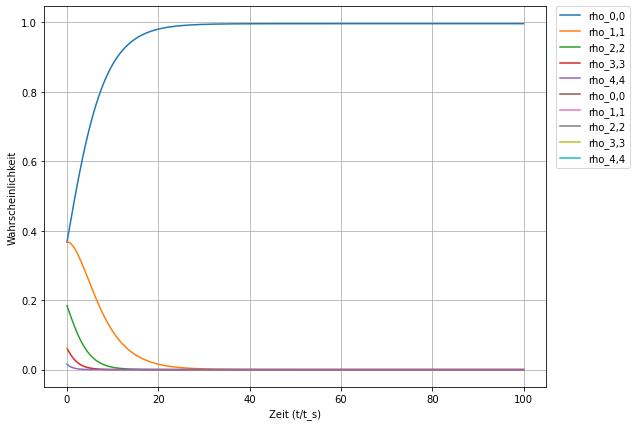

In [66]:
times = (0, 100)
c = 0.1
w_cut = 15
T = 1
matsub = 50
w = 1
D = 5


rho0 = np.array([[0]*D for i in range(D)], dtype=complex)
alpha = complex(1, 0)
rho0 = coh_mat(D, alpha)

times, rho_dynamics_rwa = odeint_solver(
    times, rho0, c,  w_cut, T, matsub, w, D, True)
dic = {}
for i in range(0, D):
    y = f'{i},{i}'
    dic["rho_{0}".format(y)] = np.array([j[i][i]
                                         for j in rho_dynamics_rwa], dtype=complex)

times2, rho_dynamics_red = odeint_solver(
    times, rho0, c,  w_cut, T, matsub, w, D, False)
dic2 = {}
for i in range(0, D):
    y = f'{i},{i}'
    dic2["rho_{0}".format(y)] = np.array([j[i][i]
                                         for j in rho_dynamics_red], dtype=complex)

#Plots
fig, ax = plt.subplots(figsize=(9, 7))
for i in dic.keys():
    plt.plot(times, np.real(dic.get(i)), label=f'{i}')
for i in dic2.keys():
    plt.plot(times2, np.real(dic2.get(i)), label=f'{i}')
ax.set_ylabel('Wahrscheinlichkeit')
ax.set_xlabel('Zeit (t/t_s)')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid()
